In [956]:
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import scipy.stats as st
import re
from openpyxl import load_workbook

### Create data frame with list of all NBA teams

In [881]:
html = urlopen('https://www.basketball-reference.com/teams/')
html_read = html.read()
bsObj = BeautifulSoup(html_read)

team_abbrev = []
for child in bsObj.find('tbody').children:
    try:
        team_url = child.find('a').get('href')
        team = re.split('/', team_url)[2]
        team_abbrev.append(team)
    except:
        pass
    
df_teams = pd.DataFrame(team_abbrev, columns=['team'])

# fix abbreviation for teams with new abbreviations in 2021 season
df_teams.iloc[2] = 'BRK'
df_teams.iloc[18] = 'NOP'
df_teams.iloc[3] = 'CHO'

### create data frame with list of all players on 2021 NBA rosters

In [882]:
df_players = pd.DataFrame(columns = ['team', 'player'])
codes = []
for team in df_teams['team']:
    team_url = urlopen('https://www.basketball-reference.com/teams/' + team + '/2021.html')
    bsObj = BeautifulSoup(team_url.read())
    for child in bsObj.find('tbody').children:
        try:
            player_url = child.find('a').get('href')
            player_url = re.split('\.', player_url)[0]
            player_code = re.split('/', player_url)[3]
            player_code = '/' + player_code[0] + '/' + player_code
            codes.append(player_code)
        except:
            pass
    df_team = pd.DataFrame(zip([team] * len(codes), codes), columns=['team', 'player'])
    df_players = pd.concat([df_players, df_team], join='outer')
    codes = []

df_players = df_players.reset_index(drop=True)

# brazdig01 is repeated twice so delete one of them (also the link doesnt work so delete both)
df_players.drop(labels=371, inplace=True)
df_players.drop(labels=372, inplace=True)

### Create data frame of all stats for each player from the 2021 season up to this point

In [883]:
stat_names = ['player','date','team','home','opp','min','FG','FGA','3P','3PA','FT','FTA','ORB','DRB','TRB','AST',
         'STL','BLK','TOV','PF','PTS','GmSc','+/-']
df_stats = pd.DataFrame(columns=stat_names)
for i, player in enumerate(df_players['player']):
    if i % 50 == 0:
        print('{}% complete'.format(round(100*i/len(df_players))))
    player_url = urlopen('https://www.basketball-reference.com/players/' + player + '/gamelog/2021')
    bsObj = BeautifulSoup(player_url.read())
    stats = []
    for child in bsObj.find('tbody').children:
        try:
            stats.append(player)
            for child1 in child.children:
                stats.append(child1.get_text())
        except:
            pass   
        # if len(stats) < 31, the player did not play that night so ignore those rows
        if len(stats) == 31:
            # get rid of unnecessary columns
            del stats[1:3]
            del stats[2]
            del stats[5:7]
            del stats[8]
            del stats[10]
            del stats[12]
            df_stats = df_stats.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns=stat_names))
        stats = []
df_stats = df_stats.reset_index(drop=True)
df_stats.to_csv('df_stats.csv')
df_stats.head()

0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
89% complete
99% complete


,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/h/hillso01,2020-12-23,ATL,@,CHI,28:24,0,3,0,3,...,3,3,0,0,1,3,2,0,-4.3,-8
1,/h/hillso01,2020-12-26,ATL,@,MEM,12:58,2,5,1,2,...,1,2,0,0,0,0,2,6,3.5,+3
2,/h/hillso01,2020-12-28,ATL,,DET,19:55,4,8,4,8,...,2,2,0,1,1,1,3,12,8.1,+14
3,/h/hillso01,2020-12-30,ATL,@,BRK,16:43,3,6,3,5,...,1,2,0,0,0,1,3,9,4.8,-9
4,/h/hillso01,2021-01-01,ATL,@,BRK,23:40,2,9,2,7,...,4,4,1,1,1,0,1,6,3.7,+20


### Cleaning the player stats data frame

In [884]:
df_stats = pd.read_csv('df_stats.csv')
df_stats.drop(columns='Unnamed: 0', axis=1, inplace=True)

# for home column, 1 means home game, 0 means road game
df_stats['home'] = np.where(df_stats['home']=='@', 1, 0)

# change min column to numeric
def min_to_numeric(value):
    minute = int(re.split(':', value)[0])
    second = int(re.split(':', value)[1])
    return minute + round(second / 60, 2)
df_stats['min'] = df_stats['min'].apply(lambda x: min_to_numeric(x))

# two null values in +/- column
label_1, label_2 = df_stats[df_stats['+/-'].isnull()].iloc[0].name, df_stats[df_stats['+/-'].isnull()].iloc[1].name
# first one: all values are 0 so drop this columns
df_stats.drop(labels=[label_1], axis=0, inplace=True)
# second one: I looked it up on espn and the value should be -4
df_stats.loc[label_2,'+/-'] = '-4'

df_stats['date'] = pd.to_datetime(df_stats['date'])

# convert relevant columns to numeric type
numeric_stats = ['FG','FGA','3P','3PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','GmSc','+/-']
for stat in numeric_stats:
    df_stats[stat] = pd.to_numeric(df_stats[stat])

df_stats.head()

,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/h/hillso01,2020-12-23,ATL,1,CHI,28.40,0,3,0,3,...,3,3,0,0,1,3,2,0,-4.3,-8.0
1,/h/hillso01,2020-12-26,ATL,1,MEM,12.97,2,5,1,2,...,1,2,0,0,0,0,2,6,3.5,3.0
2,/h/hillso01,2020-12-28,ATL,0,DET,19.92,4,8,4,8,...,2,2,0,1,1,1,3,12,8.1,14.0
3,/h/hillso01,2020-12-30,ATL,1,BRK,16.72,3,6,3,5,...,1,2,0,0,0,1,3,9,4.8,-9.0
4,/h/hillso01,2021-01-01,ATL,1,BRK,23.67,2,9,2,7,...,4,4,1,1,1,0,1,6,3.7,20.0


### Create data frame for the stats of all teams for each game

In [885]:
team_stats_names = ['date','home','Opp','W/L','score','score_Opp','FG','FGA','3P','3PA','FT','FTA','ORB','TRB','AST',
                    'STL','BLK','TOV','PF','FG_Opp','FGA_Opp','3P_Opp','3PA_Opp','FT_Opp','FTA_Opp','ORB_Opp',
                    'TRB_Opp','AST_Opp','STL_Opp','BLK_Opp','TOV_Opp','PF_Opp'
                   ]
teams_gamelog = {team: pd.DataFrame(columns=team_stats_names) for team in df_teams['team']}
for team in df_teams['team']:
    team_url = urlopen('https://www.basketball-reference.com/teams/' + team + '/2021/gamelog/')
    bsObj = BeautifulSoup(team_url.read())
    stats = []
    for child in bsObj.find('tbody').children:
        try:
            for child1 in child.children:
                stats.append(child1.get_text())
        except:
            pass 
        if len(stats) == 41:
            unnecessary_indices = [33,30,27,24,16,13,10,1,0]
            for i in unnecessary_indices:
                del stats[i]
            teams_gamelog[team] = teams_gamelog[team].append(pd.DataFrame(np.array(stats).reshape(1,-1), columns=team_stats_names))
        stats=[]
    teams_gamelog[team] = teams_gamelog[team].reset_index(drop=True)

### cleaning the team stats data frame

In [886]:
numeric_stats = ['score','score_Opp','FG','FGA','3P','3PA','FT','FTA','ORB','TRB','AST','STL','BLK','TOV','PF',
                 'FG_Opp','FGA_Opp','3P_Opp','3PA_Opp','FT_Opp','FTA_Opp','ORB_Opp','TRB_Opp','AST_Opp','STL_Opp',
                 'BLK_Opp','TOV_Opp','PF_Opp']
for team in df_teams['team']:
    teams_gamelog[team]['home'] = np.where(teams_gamelog[team]['home']=='@', 1, 0)
    teams_gamelog[team]['W/L'] = np.where(teams_gamelog[team]['W/L']=='W', 1, 0)
    teams_gamelog[team]['date'] = pd.to_datetime(teams_gamelog[team]['date'])
    for stat in numeric_stats:
        teams_gamelog[team][stat] = pd.to_numeric(teams_gamelog[team][stat])

### Create df for all players and stat of interest (points) with:
- team/opponent/player stats averaged over the last week
- player stats for entire season up to this point

In [887]:
stat = 'PTS'
df_final = pd.DataFrame()
for i, player in enumerate(df_stats['player'].unique()):
    if i % 50 == 0:
        print('{}% complete'.format(round(100*i/len(df_stats['player'].unique()))))
    df = df_stats[df_stats['player'] == player]
    df = df[['date', 'team', 'home', 'opp', stat]]

    # start in January so we have at least a week of games played already
    df = df[df['date'] >= pd.to_datetime('2021-01-01')]
    
    # add player stats averaged over the last week
    def player_week(row):
        team = row['team']
        date = row['date']
        df_player = df_stats[df_stats['player'] == player]
        df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_player_week) == 0:
            col = df_player.drop(columns=['player','date','team','opp']).columns
            AVGs = pd.Series(np.zeros(len(df_stats.columns) - 4), index=col)
        else:
            AVGs = df_player_week.drop(columns=['player','date','team','opp']).mean()
        return AVGs
    
    df_player_week = df.apply(lambda x: player_week(x), axis=1) # merge with df
    
    # add player stats averaged over season up to this point
    def player_season(row):
        date = row['date']
        df_player = df_stats[df_stats['player'] == player]
        df_player_season = df_player[df_player['date'] < date]
        if len(df_player_season) == 0:
            col = df_player.drop(columns=['player','date','team','opp']).columns
            AVGs = pd.Series(np.zeros(len(df_stats.columns) - 4), index=col)
        else:
            AVGs = df_player_season.drop(columns=['player','date','team','opp']).mean()  
        return AVGs        
    
    df_player_season = df.apply(lambda x: player_season(x), axis=1) # merge with df
    
    # add team stats averaged over the last week
    def team_week(row):
        team = row['team']
        date = row['date']
        df_team = teams_gamelog[team]
        df_team_week = df_team[(df_team['date'] < date) & (df_team['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_team_week) == 0:
            col = df_team.drop(columns=['date','Opp'], axis=1).columns
            AVGs = pd.Series(np.zeros(len(teams_gamelog[team].columns) - 2), index=col) 
        else:
            AVGs = df_team_week.drop(columns=['date','Opp'], axis=1).mean()
        return AVGs
    
    df_team_week = df.apply(lambda x: team_week(x), axis=1) # merge with df

    # add opponent stats averaged over the last week
    def opp_week(row):
        opp = row['opp']
        date = row['date']
        df_opp = teams_gamelog[opp]
        df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_opp_week) == 0:
            col = df_opp.drop(columns=['date','Opp'], axis=1).columns
            AVGs = pd.Series(np.zeros(len(teams_gamelog[opp].columns) - 2), index=col)
        else:
            AVGs = df_opp_week.drop(columns=['date','Opp'], axis=1).mean()
        return AVGs

    df_opp_week = df.apply(lambda x: opp_week(x), axis=1) # merge with df

    # merge all three df's
    df = pd.merge(df, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_playerAVG'))
    df = pd.merge(df, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_seasonAVG'))
    df = pd.merge(df, df_team_week, how='inner', left_index=True, right_index=True, suffixes=('','_teamAVG'))
    df = pd.merge(df, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_oppAVG'))

    # drop team and opp
    df.drop(columns=['team','opp'], axis=1, inplace=True)
    
    df_final = pd.concat([df_final, df])

for col in df_final.columns:
    if df_final[col].isnull().sum() == len(df_final):
        df_final.drop(columns=[col], axis=1, inplace=True)

0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete


In [888]:
# get rid of date column so only numeric columns remain
df_final.drop(columns=['date'], axis=1, inplace=True)

# get rid of rows where the player played 0 minutes
df_final = df_final[~(df_final['min'] == 0.0)]

# Model Development

In [889]:
# separate test/train data
y = df_final['PTS']
X = df_final.drop(columns=['PTS'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [890]:
# scale
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

### Ridge/Lasso Regularization

We have more features than samples so probably need lots of regularization so try ridge/lasso regression

In [891]:
ridge = Ridge()
lasso = Lasso(max_iter=50000)
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_lasso = GridSearchCV(lasso, param_grid=params, scoring='r2', cv=5)
grid_ridge = GridSearchCV(ridge, param_grid=params, scoring='r2', cv=5)

grid_lasso.fit(X_train, y_train)
grid_ridge.fit(X_train, y_train)

print('Best ridge params: {}'.format(grid_ridge.best_estimator_))
print('Best lasso params: {}'.format(grid_lasso.best_estimator_))

Best ridge params: Ridge(alpha=1000)
Best lasso params: Lasso(alpha=0.01, max_iter=50000)


In [892]:
lasso = Lasso(alpha=0.01, max_iter=50000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
y_score_lasso = lasso.score(X_test,y_test)
print('lasso score: {}'.format(y_score_lasso))

ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_score_ridge = ridge.score(X_test,y_test)
print('ridge score: {}'.format(y_score_ridge))

lasso score: 0.5404731407551204
ridge score: 0.539742013156334


Text(0.5, 0, 'predicted')

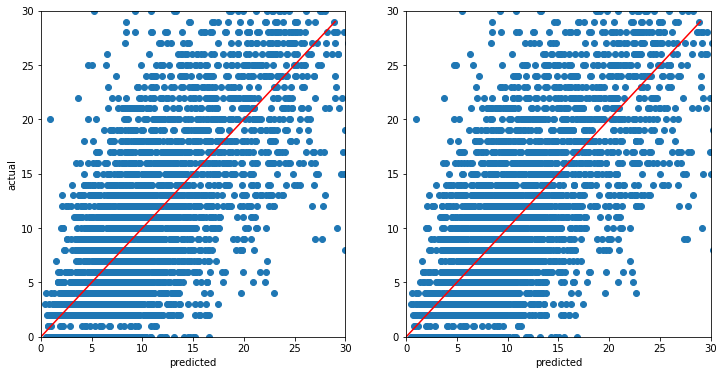

In [893]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
ax1.scatter(y_pred_lasso, y_test)
ax1.plot(np.arange(30), np.arange(30), 'r')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)
ax1.set_ylabel('actual')
ax1.set_xlabel('predicted')

ax2.scatter(y_pred_ridge, y_test)
ax2.plot(np.arange(30), np.arange(30), 'r')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)
ax2.set_xlabel('predicted')

In [894]:
pd.Series(lasso.coef_, index=X.columns).sort_values(ascending=False)[:35]

FG_seasonAVG      2.332637
FT_seasonAVG      1.056692
FGA               1.029241
min               0.840882
FGA_seasonAVG     0.810414
3PA_seasonAVG     0.480427
PTS_seasonAVG     0.292850
TOV               0.272772
FG                0.256311
TOV_seasonAVG     0.201606
FT                0.180665
FTA_oppAVG        0.173542
FTA_Opp_oppAVG    0.134623
FGA_Opp_oppAVG    0.126537
3PA_teamAVG       0.109844
+/-_seasonAVG     0.105631
FT_Opp            0.104800
AST_Opp_oppAVG    0.095558
BLK_seasonAVG     0.088328
DRB               0.086285
AST_oppAVG        0.084557
DRB_seasonAVG     0.064971
FGA_Opp           0.059361
STL_teamAVG       0.053691
AST_Opp           0.039791
FG_oppAVG         0.037649
BLK_Opp_oppAVG    0.036586
BLK_Opp           0.030426
3P_Opp            0.021257
score_Opp         0.020176
TRB_Opp_oppAVG    0.019448
STL               0.011640
home_teamAVG      0.005029
TRB_oppAVG        0.000644
ORB_Opp           0.000635
dtype: float64

The lasso regression zeros out all but 34 features to predict the number of points scored.  The most heavily weighted features include the player's season averages for field goals, field goal attempts, and free throw attempts.  The next most heavily weighted features are the player's field goal attempts and minutes played per game averaged over the last week.  Shockingly, the average points a player scored averaged over the whole season up until the game of interest had a value of 0, indicating that it was irrelevant for predicting points.  Meanwhile, that feature was the most important for the random forest regressor (see below).  It definitely seems like it would be a strong predictor of the number of points scored in a game. However, if you look at the plot below, there is high collinearity between points and field goals per game averaged over the season (intuitively makes sense).  Therefore, lasso regression likely reduced the weight of one of these to account for this collinearity.

(0.0, 14.0, 0.0, 40.0)

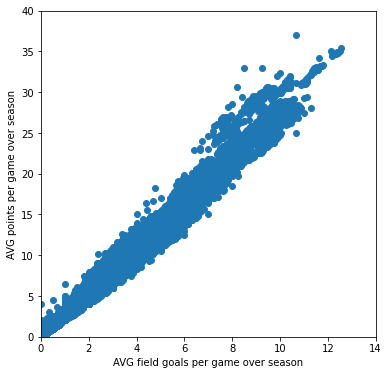

In [895]:
fig = plt.figure(figsize=(6,6))
plt.scatter(X['FG_seasonAVG'], X['PTS_seasonAVG'])
plt.xlabel('AVG field goals per game over season')
plt.ylabel('AVG points per game over season')
plt.axis([0, 14, 0, 40])

### SVR

In [896]:
svr = SVR()
params = {'kernel': ['poly', 'rbf'],
          'gamma': ['scale', 'auto'],
          'C': [0.001, 0.01, 0.1, 1, 10, 100]
         }
grid = GridSearchCV(svr, param_grid=params, scoring='r2', cv=3)
#grid.fit(X_train, y_train)
#grid.best_estimator_

# best estimator is C=1, gamma='auto'

SVR score: 0.5138046495739859


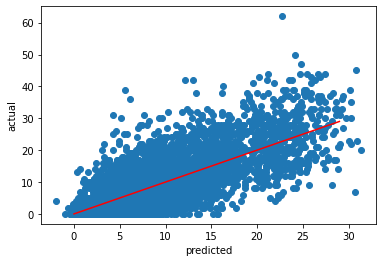

In [897]:
svr = SVR(C=1, gamma='auto', kernel='rbf')
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
_ = plt.scatter(y_pred, y_test)
_ = plt.plot(np.arange(30), np.arange(30), 'r')
plt.xlabel('predicted')
plt.ylabel('actual')
y_score_svr = svr.score(X_test,y_test)
print('SVR score: {}'.format(y_score_svr))

### Random Forests
- note that this is the best-performing model

In [898]:
tree = RandomForestRegressor()

params = {'n_estimators': [100, 200, 300],
          'max_depth': [5, 7, 9, 11],
          'max_features': [10, 20, 30, 50]
         }

#grid_tree = GridSearchCV(tree, param_grid=params, scoring='r2', cv=3)
#grid_tree.fit(X_train, y_train)

#print('Best RF params: {}'.format(grid_tree.best_estimator_))

RF score: 0.5416064644150125


Text(0.5, 1.0, 'Predicted vs. Actual Points Scored using RF model')

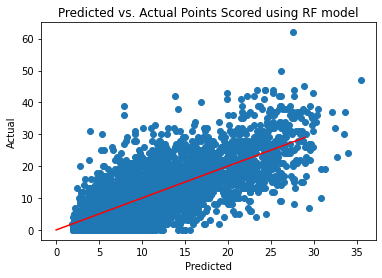

In [899]:
tree = RandomForestRegressor(max_depth=9, max_features=20, n_estimators=300)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_score_tree = tree.score(X_test,y_test)
print('RF score: {}'.format(y_score_tree))
_ = plt.scatter(y_pred_tree, y_test)
_ = plt.plot(np.arange(30), np.arange(30),'r')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual Points Scored using RF model')

In [900]:
pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]

FGA_seasonAVG     0.154530
FG_seasonAVG      0.129177
PTS_seasonAVG     0.120278
FGA               0.104749
PTS_playerAVG     0.063224
GmSc_seasonAVG    0.061287
FG                0.046820
min_seasonAVG     0.031194
FT_seasonAVG      0.027230
min               0.024053
dtype: float64

The most important features to predict point scores according to the random forest regressor is the average number of points, field goal attempts, and field goals by a player averaged over the entire season up to the point of the game of interest.

### Voting Regressor

Voting Regressor score: 0.542975897341367


Text(0, 0.5, 'Actual')

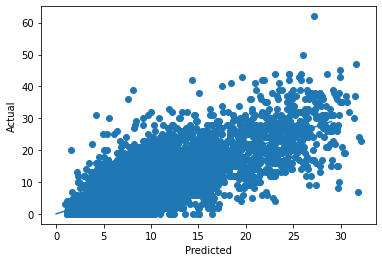

In [901]:
vote = VotingRegressor([('Ridge',ridge), ('Lasso',lasso), ('RF',tree)], n_jobs=-1)
vote.fit(X_train, y_train)
print('Voting Regressor score: {}'.format(vote.score(X_test,y_test)))
y_pred_vote = vote.predict(X_test)
_ = plt.scatter(y_pred_vote, y_test)
_ = plt.plot(np.arange(30), np.arange(30))
plt.xlabel('Predicted')
plt.ylabel('Actual')

The voting regressor is worse than the random forest model so I will use the random forest as the final model.

# Create data to predict during NBA playoffs
- this function will take information about a player for a particular game and output a prediction to compare to a over/under generated by a betting site

In [902]:
def predict_player_points(player, team, opp, home, date):

    X_predict = pd.DataFrame(np.array([date, team, home, opp]).reshape(1,-1), columns = ['date', 'team', 'home', 'opp'])
    
    # add player stats averaged over the last week
    df_player = df_stats[df_stats['player'] == player]
    df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_player_week = df_player_week.drop(columns=['player','date','team','opp']).mean()
    df_player_week = pd.DataFrame(np.array(df_player_week).reshape(1,-1), columns = df_player_week.index)

    # add player stats averaged over season up to this point
    df_player_season = df_player[df_player['date'] < date]
    df_player_season = df_player_season.drop(columns=['player','date','team','opp']).mean() 
    df_player_season = pd.DataFrame(np.array(df_player_season).reshape(1,-1), columns = df_player_season.index)

    # add team stats averaged over the last week
    df_team = teams_gamelog[team]
    df_team_week = df_team[(df_team['date'] < date) & (df_team['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_team_week = df_team_week.drop(columns=['date','Opp'], axis=1).mean()
    df_team_week = pd.DataFrame(np.array(df_team_week).reshape(1,-1), columns = df_team_week.index)

    # add opponent stats averaged over the last week
    df_opp = teams_gamelog[opp]
    df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_opp_week = df_opp_week.drop(columns=['date','Opp'], axis=1).mean()
    df_opp_week = pd.DataFrame(np.array(df_opp_week).reshape(1,-1), columns = df_opp_week.index)

    # merge all three df's
    X_predict = pd.merge(X_predict, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_playerAVG'))
    X_predict = pd.merge(X_predict, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_seasonAVG'))
    X_predict = pd.merge(X_predict, df_team_week, how='inner', left_index=True, right_index=True, suffixes=('','_teamAVG'))
    X_predict = pd.merge(X_predict, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_oppAVG'))

    # drop team and opp
    X_predict.drop(columns=['date','team','opp'], axis=1, inplace=True)

    for col in X_predict.columns:
        if X_predict[col].isnull().sum() == len(X_predict):
            X_predict.drop(columns=[col], axis=1, inplace=True)

    X_predict = scale.transform(X_predict)
    y_pred = np.round(tree.predict(X_predict), 1)
    return y_pred[0]

## Predict score of a player in today's game

In [903]:
player = '/b/bealbr01'
team = 'WAS'
opp = 'BOS'
home = 0
date = pd.to_datetime('today').normalize()
predict_player_points(player, team, opp, home, date)

28.1

# Betting
- Start with \$1,000
- At monkeyknifefight.com, you have to correctly guess the over/under for points scored by two players (one from each team in the game)
- The payout is typically 3x
    - Since you have to correctly predict two props to win the bet, I must be correct 33% of the time to come out even with a 3x payout.  This means that I must be correct 57.4% of the time for each individual prediction to come out even.  I can potentially reduce this further by betting larger amounts on bets that I am more confident in.
- Bet based on the following process:
    - determine the mean and standard deviation of the difference between actual and predicted points scored to get a normal distribution
    - determine the area under the cumulative distribution function for the difference between the over/under for a particular player and the model prediction
    - this area represents the probability that my prediction is correct
    - multiply this value times the value for the second player in the prop bet
    - if this value is greater than 0.33 (since I need to be correct at least 33% of the time for a 3x payout), make the bet based on the following formula:
        - if p > 0.33, bet = $800*p^4$
        - bet more money on bets with greater probability of success
    

### Determine mean, standard deviation of normal distribution of the difference between predicted and actual points scored on the test set

95.0% confidence interval: [-0.18  0.19]
Median: -0.6634758960637601
Mean: 0.0018825065418759553
Standard Deviation: 5.975308439534484


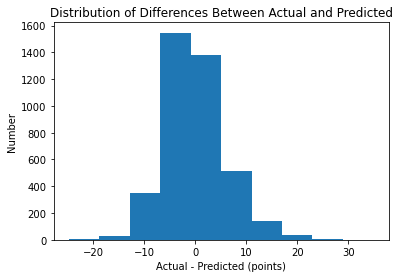

In [904]:
y_diff = y_test - y_pred_vote
_ = plt.hist(y_diff)
plt.xlabel('Actual - Predicted (points)')
plt.ylabel('Number')
plt.title('Distribution of Differences Between Actual and Predicted')

alpha = 0.95
CI = st.norm.interval(alpha=alpha, loc=np.mean(y_diff), scale=st.sem(y_diff))
print('{}% confidence interval: {}'.format(100*alpha, np.round(CI,2)))
std = st.stats.tstd(y_diff)
mean = np.mean(y_diff)
median = np.median(y_diff)
print('Median: {}'.format(median))
print('Mean: {}'.format(mean))
print('Standard Deviation: {}'.format(std))

### Calculate area under cumulative distribution function to determine probability of success and how much to bet

In [905]:
# diff = O/U - Predicted
diff1 = 4.6
diff2 = 0.6

if diff1 > 0:
    p1 = st.norm(mean,std).cdf(diff1)
else:
    p1 = 1 - st.norm(mean,std).cdf(diff1)
    
if diff2 > 0:
    p2 = st.norm(mean,std).cdf(diff2)
else:
    p2 = 1 - st.norm(mean,std).cdf(diff2)
    
p = p1 * p2
print('Probability of winning the bet: {}'.format(round(p,3)))
print('Probability of winning part 1: {}'.format(round(p1,3)))
print('Probability of winning part 2: {}'.format(round(p2,3)))
if p > 0.33:
    bet = round(800*p**4, 2)
else:
    bet = 0
print('Bet ${} on this prop'.format(bet))

Probability of winning the bet: 0.421
Probability of winning part 1: 0.779
Probability of winning part 2: 0.54
Bet $25.05 on this prop


# Model 2
### Only train model on players who averaged at least 15 points per game in 2020 since betting websites only set over/under lines for high scoring players

### Add players' actual name to players data frame (in addition to the code used by basteball reference)

In [906]:
index = df_players.index
for i, player in enumerate(df_players['player']):
    idx = index[i]
    player_url = urlopen('https://www.basketball-reference.com/players/' + player + '.html')
    bsObj = BeautifulSoup(player_url.read())
    title = bsObj.find('title').get_text()
    title = re.split(' Stats', title)[0]
    df_players.loc[idx, 'name'] = title

df_players.head()

,team,player,name
0,ATL,/h/hillso01,Solomon Hill
1,ATL,/h/huertke01,Kevin Huerter
2,ATL,/y/youngtr01,Trae Young
3,ATL,/c/collijo01,John Collins
4,ATL,/c/capelca01,Clint Capela


### Read in data set on players who averaged at least 15 points in 2020 (downloaded from basketball reference)

In [907]:
df_2020_15pts = pd.read_csv('2020_players_15pts.csv')
df_2020_15pts.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS▼
0,1.0,James Harden,SG,30.0,HOU,68.0,68.0,36.5,9.9,22.3,...,0.865,1.0,5.5,6.6,7.5,1.8,0.9,4.5,3.3,34.3
1,2.0,Bradley Beal,SG,26.0,WAS,57.0,57.0,36.0,10.4,22.9,...,0.842,0.9,3.3,4.2,6.1,1.2,0.4,3.4,2.2,30.5
2,3.0,Damian Lillard,PG,29.0,POR,66.0,66.0,37.5,9.5,20.4,...,0.888,0.5,3.8,4.3,8.0,1.1,0.3,2.9,1.7,30.0
3,4.0,Trae Young,PG,21.0,ATL,60.0,60.0,35.3,9.1,20.8,...,0.860,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6
4,5.0,Giannis Antetokounmpo,PF,25.0,MIL,63.0,63.0,30.4,10.9,19.7,...,0.633,2.2,11.4,13.6,5.6,1.0,1.0,3.7,3.1,29.5


### Eliminate players from players data frame who did not score at least 15 points 
- add back high-scoring players that were not in the list due to injury

In [908]:
index = df_players.index
df_players_15 = pd.DataFrame()
flag = 0
for i, name in enumerate(df_players['name']):
    if name in df_2020_15pts['Player'].values:
        idx = index[i]
        df_players_15[flag] = df_players.loc[idx]
        flag += 1
df_players_15 = df_players_15.unstack().unstack()

# add players to list that were injured last season
df_players_15.loc[71] = ['GSW', '/c/curryst01', 'Stephen Curry']
df_players_15.loc[72] = ['BKN', '/i/irvinky01', 'Kyrie Irving']
df_players_15.loc[73] = ['BKN', '/d/duranke01', 'Kevin Durant']

df_players_15.head()

,team,player,name
0,ATL,/y/youngtr01,Trae Young
1,ATL,/g/gallida01,Danilo Gallinari
2,ATL,/b/bogdabo01,Bogdan Bogdanović
3,ATL,/w/willilo02,Lou Williams
4,BOS,/t/tatumja01,Jayson Tatum


### Create a data frame of stats for each of these players for each game

In [909]:
stat_names = ['player','date','team','home','opp','min','FG','FGA','3P','3PA','FT','FTA','ORB','DRB','TRB','AST',
         'STL','BLK','TOV','PF','PTS','GmSc','+/-']
df_stats_15 = pd.DataFrame(columns=stat_names)
for i, player in enumerate(df_players_15['player']):
    if i % 10 == 0:
        print('{}% complete'.format(round(100*i/len(df_players_15))))
    player_url = urlopen('https://www.basketball-reference.com/players/' + player + '/gamelog/2021')
    bsObj = BeautifulSoup(player_url.read())
    stats = []
    for child in bsObj.find('tbody').children:
        try:
            stats.append(player)
            for child1 in child.children:
                stats.append(child1.get_text())
        except:
            pass   
        # if len(stats) < 31, the player did not play that night so ignore those rows
        if len(stats) == 31:
            # get rid of unnecessary columns
            del stats[1:3]
            del stats[2]
            del stats[5:7]
            del stats[8]
            del stats[10]
            del stats[12]
            df_stats_15 = df_stats_15.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns=stat_names))
        stats = []
df_stats_15 = df_stats_15.reset_index(drop=True)
df_stats_15.to_csv('df_stats_15.csv')
df_stats_15.head()

0% complete
14% complete
27% complete
41% complete
54% complete
68% complete
81% complete
95% complete


,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/y/youngtr01,2020-12-23,ATL,@,CHI,25:57,10,12,5,6,...,4,6,7,0,0,4,1,37,34.9,+30
1,/y/youngtr01,2020-12-26,ATL,@,MEM,35:23,10,24,1,7,...,1,3,9,0,0,2,1,36,28.0,+12
2,/y/youngtr01,2020-12-28,ATL,,DET,32:55,6,13,2,6,...,3,3,6,0,0,3,2,29,23.6,0
3,/y/youngtr01,2020-12-30,ATL,@,BRK,31:56,8,18,0,4,...,3,6,11,0,0,5,0,30,25.5,+5
4,/y/youngtr01,2021-01-01,ATL,@,BRK,32:27,7,21,3,8,...,3,5,7,1,1,3,2,21,14.2,+11


### Clean the player stats data set

In [910]:
df_stats_15['home'] = np.where(df_stats_15['home']=='@', 1, 0)

# change min column to numeric
def min_to_numeric(value):
    minute = int(re.split(':', value)[0])
    second = int(re.split(':', value)[1])
    return minute + round(second / 60, 2)
df_stats_15['min'] = df_stats_15['min'].apply(lambda x: min_to_numeric(x))

df_stats_15['date'] = pd.to_datetime(df_stats_15['date'])

# convert relevant columns to numeric type
numeric_stats = ['FG','FGA','3P','3PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','GmSc','+/-']
for stat in numeric_stats:
    df_stats_15[stat] = pd.to_numeric(df_stats_15[stat])
    
df_stats_15.head()

,player,date,team,home,opp,min,FG,FGA,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,/y/youngtr01,2020-12-23,ATL,1,CHI,25.95,10,12,5,6,...,4,6,7,0,0,4,1,37,34.9,30
1,/y/youngtr01,2020-12-26,ATL,1,MEM,35.38,10,24,1,7,...,1,3,9,0,0,2,1,36,28.0,12
2,/y/youngtr01,2020-12-28,ATL,0,DET,32.92,6,13,2,6,...,3,3,6,0,0,3,2,29,23.6,0
3,/y/youngtr01,2020-12-30,ATL,1,BRK,31.93,8,18,0,4,...,3,6,11,0,0,5,0,30,25.5,5
4,/y/youngtr01,2021-01-01,ATL,1,BRK,32.45,7,21,3,8,...,3,5,7,1,1,3,2,21,14.2,11


### Create df for players and stat of interest (points) with:
- team/opponent/player stats averaged over the last week
- player stats for entire season up to this point

In [911]:
stat = 'PTS'
df_final_15 = pd.DataFrame()
for i, player in enumerate(df_stats_15['player'].unique()):
    if i % 10 == 0:
        print('{}% complete'.format(round(100*i/len(df_stats_15['player'].unique()))))
    df = df_stats_15[df_stats_15['player'] == player]
    df = df[['date', 'team', 'home', 'opp', stat]]

    # start in January so we have at least a week of games played already
    df = df[df['date'] >= pd.to_datetime('2021-01-01')]
    
    # add player stats averaged over the last week
    def player_week(row):
        team = row['team']
        date = row['date']
        df_player = df_stats_15[df_stats_15['player'] == player]
        df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_player_week) == 0:
            col = df_player.drop(columns=['player','date','team','opp']).columns
            AVGs = pd.Series(np.zeros(len(df_stats.columns) - 4), index=col)
        else:
            AVGs = df_player_week.drop(columns=['player','date','team','opp']).mean()
        return AVGs
    
    df_player_week = df.apply(lambda x: player_week(x), axis=1) # merge with df
    
    # add player stats averaged over season up to this point
    def player_season(row):
        date = row['date']
        df_player = df_stats_15[df_stats_15['player'] == player]
        df_player_season = df_player[df_player['date'] < date]
        if len(df_player_season) == 0:
            col = df_player.drop(columns=['player','date','team','opp']).columns
            AVGs = pd.Series(np.zeros(len(df_stats.columns) - 4), index=col)
        else:
            AVGs = df_player_season.drop(columns=['player','date','team','opp']).mean()  
        return AVGs        
    
    df_player_season = df.apply(lambda x: player_season(x), axis=1) # merge with df
    
    # add team stats averaged over the last week
    def team_week(row):
        team = row['team']
        date = row['date']
        df_team = teams_gamelog[team]
        df_team_week = df_team[(df_team['date'] < date) & (df_team['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_team_week) == 0:
            col = df_team.drop(columns=['date','Opp'], axis=1).columns
            AVGs = pd.Series(np.zeros(len(teams_gamelog[team].columns) - 2), index=col) 
        else:
            AVGs = df_team_week.drop(columns=['date','Opp'], axis=1).mean()
        return AVGs
    
    df_team_week = df.apply(lambda x: team_week(x), axis=1) # merge with df

    # add opponent stats averaged over the last week
    def opp_week(row):
        opp = row['opp']
        date = row['date']
        df_opp = teams_gamelog[opp]
        df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
        if len(df_opp_week) == 0:
            col = df_opp.drop(columns=['date','Opp'], axis=1).columns
            AVGs = pd.Series(np.zeros(len(teams_gamelog[opp].columns) - 2), index=col)
        else:
            AVGs = df_opp_week.drop(columns=['date','Opp'], axis=1).mean()
        return AVGs

    df_opp_week = df.apply(lambda x: opp_week(x), axis=1) # merge with df

    # merge all three df's
    df = pd.merge(df, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_playerAVG'))
    df = pd.merge(df, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_seasonAVG'))
    df = pd.merge(df, df_team_week, how='inner', left_index=True, right_index=True, suffixes=('','_teamAVG'))
    df = pd.merge(df, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_oppAVG'))

    # drop team and opp
    df.drop(columns=['team','opp'], axis=1, inplace=True)
    
    df_final_15 = pd.concat([df_final_15, df])

for col in df_final_15.columns:
    if df_final_15[col].isnull().sum() == len(df_final_15):
        df_final_15.drop(columns=[col], axis=1, inplace=True)

df_final_15.drop(columns=['date'], axis=1, inplace=True)

0% complete
14% complete
27% complete
41% complete
54% complete
68% complete
81% complete
95% complete


### Get rid of rows with lots of 0s
- player was likely coming off injury, which might skew predictions unnecessarily
- could also represent game right after all-star break where game had not been played in over a week

In [912]:
def number_zeroes(row):
    values = row.values
    flag = 0
    for value in values:
        if value == 0:
            flag += 1
    if flag > 20:
        return 1
    else:
        return 0

mask = df_final_15.apply(lambda x: number_zeroes(x), axis=1)
mask = mask.values
mask = mask == 0

df_final_15 = df_final_15.iloc[mask]

### get rid of rows where points scored = 0 
- player likely was injured and did not play

In [913]:
df_final_15 = df_final_15[df_final_15['PTS'] > 0]

# Model Development

In [914]:
y_15 = df_final_15['PTS']
X_15 = df_final_15.drop(columns=['PTS'], axis=1)
X_15_train, X_15_test, y_15_train, y_15_test = train_test_split(X_15, y_15, random_state=0, test_size=0.2)

scale_15 = StandardScaler()
X_15_train = scale_15.fit_transform(X_15_train)
X_15_test = scale_15.transform(X_15_test)

### Random Forests

In [915]:
tree_15 = RandomForestRegressor()

params = {'n_estimators': [100, 200, 300],
          'max_depth': [5, 7, 9, 11],
          'max_features': [10, 20, 30, 50]
         }

grid_tree_15 = GridSearchCV(tree_15, param_grid=params, scoring='r2', cv=3)
#grid_tree_15.fit(X_15_train, y_15_train)

#print('Best RF params: {}'.format(grid_tree_15.best_estimator_))

RF score: 0.32793903311310446


Text(0.5, 0, 'Predicted')

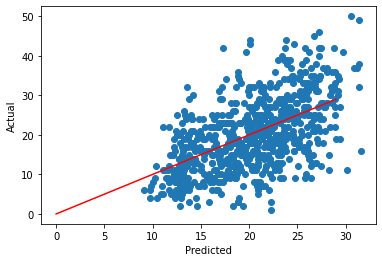

In [916]:
tree_15 = RandomForestRegressor(max_depth=7, max_features=10, n_estimators=200)
tree_15.fit(X_15_train, y_15_train)
y_15_pred_tree = tree_15.predict(X_15_test)
y_15_score_tree = tree_15.score(X_15_test,y_15_test)
print('RF score: {}'.format(y_15_score_tree))
_ = plt.scatter(y_15_pred_tree, y_15_test)
_ = plt.plot(np.arange(30), np.arange(30), 'r')
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Ridge/Lasso Regression

In [917]:
ridge_15 = Ridge()
lasso_15 = Lasso(max_iter=100000)
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_lasso_15 = GridSearchCV(lasso_15, param_grid=params, scoring='r2', cv=5)
grid_ridge_15 = GridSearchCV(ridge_15, param_grid=params, scoring='r2', cv=5)

#grid_lasso_15.fit(X_15_train, y_15_train)
#grid_ridge_15.fit(X_15_train, y_15_train)

#print('Best ridge params: {}'.format(grid_ridge_15.best_estimator_))
#print('Best lasso params: {}'.format(grid_lasso_15.best_estimator_))

In [918]:
lasso_15 = Lasso(alpha=0.1, max_iter=100000)
lasso_15.fit(X_15_train, y_15_train)
y_15_pred_lasso = lasso_15.predict(X_15_test)
y_15_score_lasso = lasso_15.score(X_15_test,y_15_test)
print('lasso score: {}'.format(y_15_score_lasso))

ridge_15 = Ridge(alpha=1000)
ridge_15.fit(X_15_train, y_15_train)
y_15_pred_ridge = ridge_15.predict(X_15_test)
y_15_score_ridge = ridge_15.score(X_15_test,y_15_test)
print('ridge score: {}'.format(y_15_score_ridge))

lasso score: 0.32533040615444586
ridge score: 0.3238066249995536


### Voting Regressor

Voting Regressor score: 0.3298529553458104


Text(0, 0.5, 'Actual')

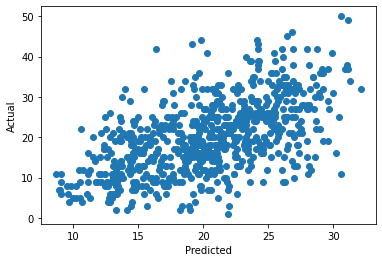

In [919]:
vote_15 = VotingRegressor([('Ridge',ridge_15), ('Lasso',lasso_15), ('RF',tree_15)], n_jobs=-1)
vote_15.fit(X_15_train, y_15_train)
print('Voting Regressor score: {}'.format(vote_15.score(X_15_test,y_15_test)))
y_15_pred_vote = vote_15.predict(X_15_test)
_ = plt.scatter(y_15_pred_vote, y_15_test)
_ = plt.plot(np.arange(30), np.arange(30), 'r')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Unlike the original model, the voting regressor performs better than individual models so I will use it as the final model

### Determine mean, standard deviation of normal distribution of the difference between predicted and actual points scored on the test set

Median: -0.4784898592448137
Mean: -0.18633318896740372
Standard Deviation: 7.431674080342586


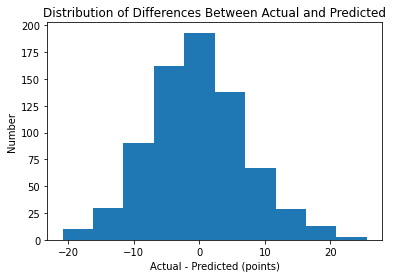

In [920]:
y_15_diff = y_15_test - y_15_pred_vote
_ = plt.hist(y_15_diff)
plt.xlabel('Actual - Predicted (points)')
plt.ylabel('Number')
plt.title('Distribution of Differences Between Actual and Predicted')

std_15 = st.stats.tstd(y_15_diff)
mean_15 = np.mean(y_15_diff)
median_15 = np.median(y_15_diff)
print('Median: {}'.format(median_15))
print('Mean: {}'.format(mean_15))
print('Standard Deviation: {}'.format(std_15))

# Create data to predict during NBA playoffs
- this function will take information about a player for a particular game and output a prediction using the second model to compare to a over/under generated by a betting site

In [921]:
def predict_player_points_15(player, team, opp, home, date):

    X_predict = pd.DataFrame(np.array([date, team, home, opp]).reshape(1,-1), columns = ['date', 'team', 'home', 'opp'])
    
    # add player stats averaged over the last week
    df_player = df_stats_15[df_stats_15['player'] == player]
    df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_player_week = df_player_week.drop(columns=['player','date','team','opp']).mean()
    df_player_week = pd.DataFrame(np.array(df_player_week).reshape(1,-1), columns = df_player_week.index)

    # add player stats averaged over season up to this point
    df_player_season = df_player[df_player['date'] < date]
    df_player_season = df_player_season.drop(columns=['player','date','team','opp']).mean() 
    df_player_season = pd.DataFrame(np.array(df_player_season).reshape(1,-1), columns = df_player_season.index)

    # add team stats averaged over the last week
    df_team = teams_gamelog[team]
    df_team_week = df_team[(df_team['date'] < date) & (df_team['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_team_week = df_team_week.drop(columns=['date','Opp'], axis=1).mean()
    df_team_week = pd.DataFrame(np.array(df_team_week).reshape(1,-1), columns = df_team_week.index)

    # add opponent stats averaged over the last week
    df_opp = teams_gamelog[opp]
    df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_opp_week = df_opp_week.drop(columns=['date','Opp'], axis=1).mean()
    df_opp_week = pd.DataFrame(np.array(df_opp_week).reshape(1,-1), columns = df_opp_week.index)

    # merge all three df's
    X_predict = pd.merge(X_predict, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_playerAVG'))
    X_predict = pd.merge(X_predict, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_seasonAVG'))
    X_predict = pd.merge(X_predict, df_team_week, how='inner', left_index=True, right_index=True, suffixes=('','_teamAVG'))
    X_predict = pd.merge(X_predict, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_oppAVG'))

    # drop team and opp
    X_predict.drop(columns=['date','team','opp'], axis=1, inplace=True)

    for col in X_predict.columns:
        if X_predict[col].isnull().sum() == len(X_predict):
            X_predict.drop(columns=[col], axis=1, inplace=True)

    X_predict = scale_15.transform(X_predict)
    y_pred = np.round(vote_15.predict(X_predict), 1)
    return y_pred[0]


## Predict score of a player in today's game using both models

In [922]:
player = '/t/tatumja01'
team = 'BOS'
opp = 'WAS'
home = 1
date = pd.to_datetime('today').normalize()
print('Original model prediction: {}'.format(predict_player_points(player, team, opp, home, date)))
print('Model_15 prediction: {}'.format(predict_player_points_15(player, team, opp, home, date)))

Original model prediction: 28.2
Model_15 prediction: 27.0


### Calculate area under cumulative distribution function to determine probability of success / how much to bet

In [923]:
# diff = O/U - Predicted
diff1 = 2.5
diff2 = 1.4

diff1_15 = 4.7
diff2_15 = 3.6

std = st.stats.tstd(y_diff)
mean = np.mean(y_diff)
std_15 = st.stats.tstd(y_15_diff)
mean_15 = np.mean(y_15_diff)

if diff1 > 0:
    p1 = st.norm(mean,std).cdf(diff1)
else:
    p1 = 1 - st.norm(mean,std).cdf(diff1)
    
if diff2 > 0:
    p2 = st.norm(mean,std).cdf(diff2)
else:
    p2 = 1 - st.norm(mean,std).cdf(diff2)
    
p = p1 * p2
print('Original Model')
print('Probability of winning the bet: {}'.format(round(p,3)))
print('Probability of winning part 1: {}'.format(round(p1,3)))
print('Probability of winning part 2: {}'.format(round(p2,3)))
if p > 0.33:
    bet = round(800*p**4, 2)
else:
    bet = 0
print('Bet ${} on this prop'.format(bet))


if diff1_15 > 0:
    p1 = st.norm(mean_15,std_15).cdf(diff1_15)
else:
    p1 = 1 - st.norm(mean_15,std_15).cdf(diff1_15)
    
if diff2_15 > 0:
    p2 = st.norm(mean_15,std_15).cdf(diff2_15)
else:
    p2 = 1 - st.norm(mean_15,std_15).cdf(diff2_15)
    
p = p1 * p2
print('')
print('Model_15')
print('Probability of winning the bet: {}'.format(round(p,3)))
print('Probability of winning part 1: {}'.format(round(p1,3)))
print('Probability of winning part 2: {}'.format(round(p2,3)))
if p > 0.33:
    bet = round(800*p**4, 2)
else:
    bet = 0
print('Bet ${} on this prop'.format(bet))

Original Model
Probability of winning the bet: 0.392
Probability of winning part 1: 0.662
Probability of winning part 2: 0.593
Bet $18.94 on this prop

Model_15
Probability of winning the bet: 0.517
Probability of winning part 1: 0.745
Probability of winning part 2: 0.695
Bet $57.3 on this prop


### Look at model predictions from data set on particular player

Text(0.5, 1.0, 'Predicted vs. Actual Points Scored by /i/irvinky01')

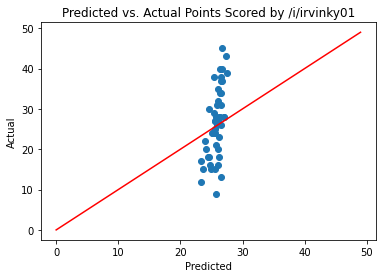

In [924]:
plyr = '/i/irvinky01'
plyr_stats = df_stats_15[df_stats_15['player'] == plyr]
plyr_idx = plyr_stats.index

plyr_X_idx = []
for idx in plyr_idx:
    if idx in X_15.index:
        plyr_X_idx.append(idx)
plyr_X = X_15.loc[plyr_X_idx]
plyr_y = y_15.loc[plyr_X_idx]

plyr_X = scale_15.transform(plyr_X)
plyr_y_pred = tree_15.predict(plyr_X)

_ = plt.scatter(plyr_y_pred, plyr_y)
_ = plt.plot(np.arange(50), np.arange(50), 'r')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual Points Scored by {}'.format(plyr))

In [925]:
df_players_15.head()

,team,player,name
0,ATL,/y/youngtr01,Trae Young
1,ATL,/g/gallida01,Danilo Gallinari
2,ATL,/b/bogdabo01,Bogdan Bogdanović
3,ATL,/w/willilo02,Lou Williams
4,BOS,/t/tatumja01,Jayson Tatum


# Main
### enter game info and write all data to excel file

In [963]:
# enter game info
name1 = 'DeMar DeRozan'  # home player
OU1 = 24.5
name2 = 'Dillon Brooks' # road player
OU2 = 20.5

playoff_round = 0
game = 1
bet_id = 2

date = pd.to_datetime('today').normalize()

########
player1 = df_players_15[df_players_15['name'] == name1]['player'].values[0]
player2 = df_players_15[df_players_15['name'] == name2]['player'].values[0]

team1 = df_players_15[df_players_15['name'] == name1]['team'].values[0]
team2 = df_players_15[df_players_15['name'] == name2]['team'].values[0]

pred1 = predict_player_points(player1, team1, team2, 1, date)
pred1_15 = predict_player_points_15(player1, team1, team2, 1, date)
pred2 = predict_player_points(player2, team2, team1, 0, date)
pred2_15 = predict_player_points_15(player2, team2, team1, 0, date)

diff1 = OU1 - pred1
diff1_15 = OU1 - pred1_15
diff2 = OU2 - pred2
diffd_15 = OU2 - pred2_15

std = st.stats.tstd(y_diff)
mean = np.mean(y_diff)
std_15 = st.stats.tstd(y_15_diff)
mean_15 = np.mean(y_15_diff)

####### determine probability of success for bets on first model
if diff1 > 0:
    p1 = st.norm(mean,std).cdf(diff1)
else:
    p1 = 1 - st.norm(mean,std).cdf(diff1)
    
if diff2 > 0:
    p2 = st.norm(mean,std).cdf(diff2)
else:
    p2 = 1 - st.norm(mean,std).cdf(diff2)
    
p = p1 * p2
if p > 0.33:
    bet = round(800*p**4, 2)
else:
    bet = 0

####### determine probability of success for bets on second model
if diff1_15 > 0:
    p1_15 = st.norm(mean_15,std_15).cdf(diff1_15)
else:
    p1_15 = 1 - st.norm(mean_15,std_15).cdf(diff1_15)
    
if diff2_15 > 0:
    p2_15 = st.norm(mean_15,std_15).cdf(diff2_15)
else:
    p2_15 = 1 - st.norm(mean_15,std_15).cdf(diff2_15)
    
p_15 = p1_15 * p2_15

if p_15 > 0.33:
    bet_15 = round(800*p_15**4, 2)
else:
    bet_15 = 0

####### determine whether to bet over or under
if OU1-pred1 > 0:
    OU1_bet = 0
else:
    OU1_bet = 1

if OU1-pred1_15 > 0:
    OU1_bet_15 = 0
else:
    OU1_bet_15 = 1

if OU2-pred2 > 0:
    OU2_bet = 0
else:
    OU2_bet = 1

if OU2-pred2_15 > 0:
    OU2_bet_15 = 0
else:
    OU2_bet_15 = 1

# format everything into a row of the excel file
New_row_1 = np.array([name1, player1, team1, team2, 1, playoff_round, game, pred1, pred1_15, OU1, 
                      np.round(OU1-pred1, 3), np.round(OU1-pred1_15, 3), np.round(p1, 3), np.round(p1_15, 3), 
                      bet, bet_15, bet_id, OU1_bet, OU1_bet_15, '?', '?', '?', '?', '?', '?', '?', '?'])
New_row_2 = np.array([name2, player2, team2, team1, 0, playoff_round, game, pred2, pred2_15, OU2, 
                      np.round(OU2-pred2, 3), np.round(OU2-pred2_15, 3), np.round(p2, 3), np.round(p2_15, 3), 
                      bet, bet_15, bet_id, OU2_bet, OU2_bet_15, '?', '?', '?', '?', '?', '?', '?', '?'])

New_rows = np.concatenate((New_row_1.reshape(1,-1), New_row_2.reshape(1,-1)), axis=0)

columns = ['Player', 'Player Code', 'Team', 'Opp', 'Home', 'Round', 'Game', 'Prediction',
           'Prediction_15', 'O/U', 'Line Diff', 'Line Diff_15', 'Prob', 'Prob_15',
           'Wager', 'Wager_15', 'Bet ID', 'O/U bet',  'O/U bet_15','Actual', 'Diff', 'Diff_15',
           'Correct', 'Win', 'Win_15', 'Money', 'Money_15'
          ]
df_rows = pd.DataFrame(New_rows, columns = columns)

######## write the two rows into the excel file
writer = pd.ExcelWriter('Playoff_prop_bets2.xlsx', engine='openpyxl')
# try to open an existing workbook
writer.book = load_workbook('Playoff_prop_bets2.xlsx')
# copy existing sheets
writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
# read existing file
reader = pd.read_excel(r'Playoff_prop_bets2.xlsx')
# write out the new sheet
df_rows.to_excel(writer,index=False,header=False,startrow=len(reader)+1)
writer.close()